<a href="https://colab.research.google.com/github/Aligreu/Text-Based-Projects/blob/main/finetuneBertForTextAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, BertModel

In [5]:
!unzip /content/twitterRedditdatasets.zip

Archive:  /content/twitterRedditdatasets.zip
  inflating: Reddit_Data.csv         
  inflating: Twitter_Data.csv        


In [6]:
twitter_data = pd.read_csv("/content/Twitter_Data.csv")
twitter_data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [21]:
twitter_data['category'] = twitter_data.category.replace({
    -1:'Negative',
    0:'Normal',
    1:"Positive"
})

In [22]:
twitter_data.shape

(162980, 2)

In [23]:
data = twitter_data.sample(n=15000, random_state=42)

In [24]:
data.category.value_counts()

Positive    6676
Normal      5019
Negative    3305
Name: category, dtype: int64

In [25]:
X = data['clean_text'].to_list()
Y = data['category']

In [29]:
from sklearn.preprocessing import LabelBinarizer

Y_encode = LabelBinarizer().fit_transform(Y)

In [30]:
Y_encode[:5, :]

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

#### data is clean so i will apply bert directly.

In [13]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf



max_length = max([len(sent.split()) for sent in X])

bert_model = TFBertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [14]:
def preprocess_data(X, Y):

    ids = np.zeros((len(X), max_length))
    masks = np.zeros((len(X), max_length))

    for i, sentance in enumerate(X):
        output_tokens = tokenizer(sentance,
                             max_length=max_length,
                             truncation=True,
                             padding='max_length',
                             add_special_tokens=True,
                             return_attention_mask=True,
                             return_tensors='tf')

        ids[i, :], masks[i,:] = output_tokens['input_ids'], output_tokens['attention_mask']

    dataset = tf.data.Dataset.from_tensor_slices((ids, masks, Y))

    def helper(ids, masks, Y):
        return {
            'input_ids':ids,
            'attention_mask':masks
        }, Y

    dataset = dataset.map(helper)
    dataset = dataset.shuffle(1000000).batch(batch_size=32)
    return dataset

In [15]:
dataset = preprocess_data(X, Y_encode)

In [16]:
train_size = int(0.8 * len(dataset))

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

### Model Building

In [19]:
from tensorflow import keras

input_ids = keras.layers.Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = keras.layers.Input(shape=(max_length,), name='attention_mask', dtype='int32')
bert_layer = bert_model(input_ids, attention_mask=attention_mask)[0]

cnn_layer = keras.layers.Conv1D(filters=64, kernel_size=3, activation=tf.nn.relu)(bert_layer)
max_pool = keras.layers.MaxPooling1D(2)(cnn_layer)
avgerage_pooling_layer = keras.layers.GlobalAveragePooling1D()(max_pool)
batch_norm_layer = keras.layers.BatchNormalization()(avgerage_pooling_layer)

dense_layer = keras.layers.Dense(128, activation=tf.nn.relu)(batch_norm_layer)
output_layer = keras.layers.Dense(3, activation=tf.nn.softmax)(dense_layer)

model = keras.models.Model(inputs=[input_ids, attention_mask], outputs=output_layer)
model.layers[2].trainable = False


model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [20]:
early_stoping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=test_dataset,
                    batch_size=64,
                    callbacks=[early_stoping])

Epoch 1/100
375/375 [==============================] - 77s 159ms/step - loss: 0.9093 - accuracy: 0.5701 - val_loss: 0.8301 - val_accuracy: 0.6213
Epoch 2/100
375/375 [==============================] - 56s 148ms/step - loss: 0.8353 - accuracy: 0.6183 - val_loss: 0.7707 - val_accuracy: 0.6420
Epoch 3/100
375/375 [==============================] - 55s 145ms/step - loss: 0.7861 - accuracy: 0.6455 - val_loss: 0.7486 - val_accuracy: 0.6640
Epoch 4/100
375/375 [==============================] - 55s 147ms/step - loss: 0.7459 - accuracy: 0.6706 - val_loss: 0.7052 - val_accuracy: 0.6820
Epoch 5/100
375/375 [==============================] - 56s 149ms/step - loss: 0.7094 - accuracy: 0.6949 - val_loss: 0.6887 - val_accuracy: 0.7043
Epoch 6/100
375/375 [==============================] - 66s 174ms/step - loss: 0.6797 - accuracy: 0.7083 - val_loss: 0.6634 - val_accuracy: 0.7080
Epoch 7/100
375/375 [==============================] - 56s 147ms/step - loss: 0.6452 - accuracy: 0.7300 - val_loss: 0.5488 -

In [31]:
_, accuracy = model.evaluate(test_dataset)

94/94 [==============================] - 13s 128ms/step - loss: 0.0520 - accuracy: 0.9860


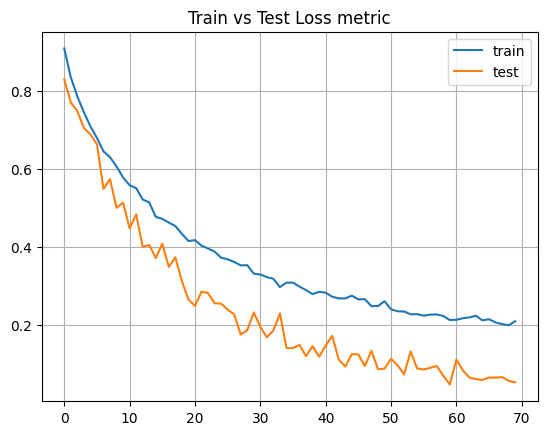

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.title("Train vs Test Loss metric")
plt.show()

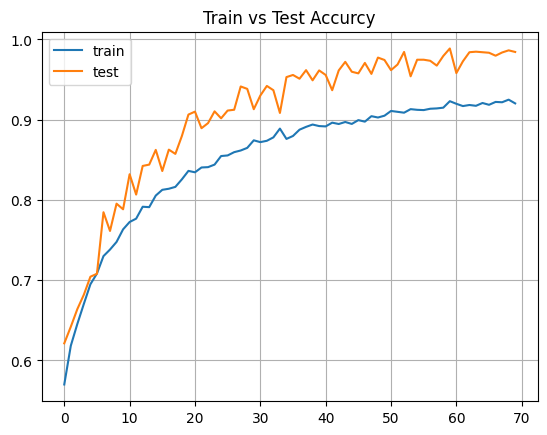

In [34]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.grid()
plt.title("Train vs Test Accurcy")
plt.show()

In [36]:
model.save("sentimentModel.h5")